# Neural Process example implementation for Mixture Density Learning

In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
from typing import Callable, Sequence, Any
from functools import partial

import jax
import jax.numpy as jnp

import flax
import flax.linen as nn

import optax
import jaxopt

import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from functions import Fourier, Mixture, Slope, Polynomial, WhiteNoise, Shift
from networks import MixtureNeuralProcess, MLP, MeanAggregator, SequenceAggregator, NonLinearMVN, ResBlock

rng = jax.random.key(0)
print('cuda?', jax.devices(), jax.devices()[0].device_kind)

cuda? [CpuDevice(id=0)] cpu


In [3]:
# Test-configuration
dataset_size = 128
test_resolution = 512

In [4]:
# Train-configuration
num_posterior_mc = 1  # number of latents to sample from p(Z | X, Y)
batch_size = 128  # number of functions to sample from p(Z)

kl_penalty = 1e-4  # Note to self: magnitude of the kl-divergence can take over in the loss
num_target_samples = 32
num_context_samples = 64

## Define Training Distribution/ Data-Generation

In [48]:
f1 = Fourier(n=3, amplitude=.5, period=1.0)
f2 = Fourier(n=2, amplitude=.5, period=1.0)
f3 = Fourier(n=6, amplitude=.5, period=2.0)
f4 = Fourier(n=3, amplitude=1.0, period=2.0)

m = Mixture([Shift(f1, y_shift=-2), Shift(f2, y_shift=0.0), Shift(f3, y_shift=2)])
nm = Mixture([WhiteNoise(m.branches[0], 0.05), WhiteNoise(m.branches[1], 0.2), WhiteNoise(m.branches[2], 0.1)])

rng = jax.random.key(0)

In [6]:
### Define joint-sampler

def joint(
    module: nn.Module, 
    data_sampler: Callable[
        [nn.Module, flax.typing.VariableDict, flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ],
    key: flax.typing.PRNGKey, 
    return_params: bool = False
) -> tuple[jax.Array, jax.Array]:
    # Samples from p(Z, X, Y)
    key_param, key_rng, key_data = jax.random.split(key, 3)
    
    params = module.init({'param': key_param, 'default': key_rng}, jnp.zeros(()))
    xs, ys = data_sampler(module, params, key_data)

    if return_params:
        return xs, ys, params
    return xs, ys


def uniform(
    module: nn.Module, 
    params: flax.typing.VariableDict, 
    key: flax.typing.PRNGKey, 
    n: int,
    bounds: tuple[float, float]
) -> tuple[jax.Array, jax.Array]:
    
    # Samples from p(X, Y | Z) = p(Y | Z, X)p(X)
    key_xs, key_ys = jax.random.split(key)
    xs = jax.random.uniform(key_xs, (n,)) * (bounds[1] - bounds[0]) + bounds[0]

    ys = jax.vmap(module.apply, in_axes=(None, 0))(params, xs, rngs={'default': jax.random.split(key_ys, n)})

    return xs, ys

<Axes: xlabel='None', ylabel='None'>

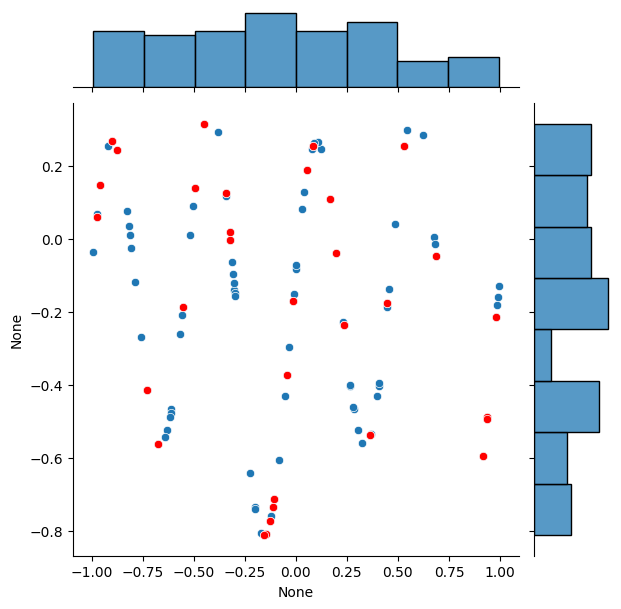

In [53]:
# Specify which function-prior to learn
data_sampler = partial(
    joint, 
    # Mixture([WhiteNoise(Shift(f2, y_shift=1.0), 0.05), WhiteNoise(Shift(f4, y_shift=-1.0), 0.2)]), 
    Mixture([f1]),
    #m,
    partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
)
# data_sampler = partial(
#     joint, 
#     WhiteNoise(f2, 0.1), 
#     partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1))
# )

rng, key = jax.random.split(rng)
xs, ys = data_sampler(key)

X, x_target = jnp.split(xs, indices_or_sections=(num_context_samples, ))
y, y_target = jnp.split(ys, indices_or_sections=(num_context_samples, ))

sns.jointplot(x=xs, y=ys)
sns.scatterplot(x=x_target, y=y_target, color='red')  # prediction targets

## Define Test-Case

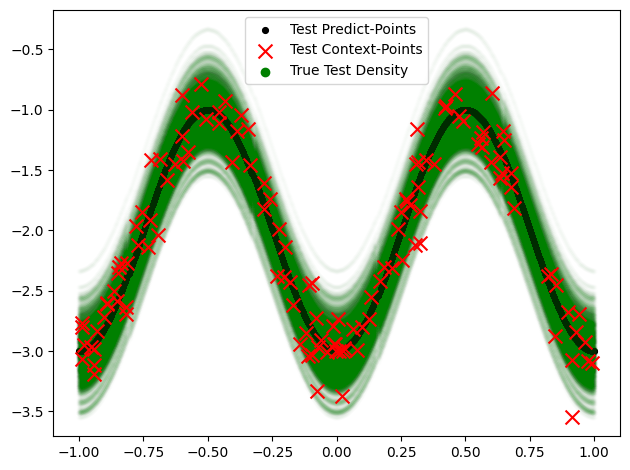

In [55]:

# def f(
#     key: flax.typing.PRNGKey, 
#     x: jax.Array, 
#     noise_scale: float = 0.2, 
#     mixture_prob: float = 0.5, 
#     corrupt: bool = True
# ):
#     key_noise, key_mixture = jax.random.split(key)
    
#     noise = jax.random.normal(key, x.shape) * noise_scale
#     choice = jax.random.bernoulli(key_mixture, mixture_prob, x.shape)

#     # return choice * (jnp.sin(2 * jnp.pi * x / 2)) + (1 - choice) * (jnp.cos(2 * jnp.pi * 2 * x)) + corrupt * noise
#     return choice * (-2-jnp.cos(2 * jnp.pi * x)) + (1 - choice) * (2+jnp.cos(2 * jnp.pi * x)) + corrupt * noise


def f(
    key: flax.typing.PRNGKey, 
    x: jax.Array, 
    noise_scale: float = 0.2, 
    mixture_prob: float = 0.5, 
    corrupt: bool = True
):
    key_noise, key_mixture = jax.random.split(key)
    
    noise = jax.random.normal(key, x.shape) * noise_scale

    # return choice * (jnp.sin(2 * jnp.pi * x / 2)) + (1 - choice) * (jnp.cos(2 * jnp.pi * 2 * x)) + corrupt * noise
    return(-2-jnp.cos(2 * jnp.pi * x)) + corrupt * noise



rng, key_data, key_test, key_x = jax.random.split(rng, 4)

keys_data = jax.random.split(key_data, (dataset_size,))
keys_test = jax.random.split(key_test, (test_resolution,))

xs = jax.random.uniform(key_x, (dataset_size,)) * 2 - 1
ys = jax.vmap(f)(keys_data, xs)

x_test = jnp.linspace(-1, 1, test_resolution)
y_test = jax.vmap(partial(f, corrupt=False))(keys_test, x_test)

# Repeat the random keys for each x-point. Roughly gives an idea of the spread
y_test_samples = jax.vmap(jax.vmap(
    partial(f, corrupt=True), in_axes=(0, None)), in_axes=(None, 0))(keys_test, x_test)

# True Function
plt.scatter(x_test, y_test, c='black', s=10, marker='o', linewidth=2, label='Test Predict-Points')
plt.scatter(
    jnp.broadcast_to(x_test, y_test_samples.shape).T, 
    y_test_samples, c='green', s=5, marker='o', linewidth=2, alpha=0.01,
)
plt.scatter(xs, ys, c='red', marker='x', s=100, label='Test Context-Points')

plt.scatter([], [], c='green', marker='o', label='True Test Density')
plt.legend()

plt.tight_layout()
plt.show()

# Define the Model

In [13]:
# Construct the NP model

embedding_xs = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
embedding_ys = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
embedding_both = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)

projection_posterior = NonLinearMVN(MLP([128, 64], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True))
output_model = nn.Sequential([
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    nn.Dense(2)
])
# output_model = MLP([64, 64, 2], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True)
projection_outputs = NonLinearMVN(output_model)

posterior_aggregator = MeanAggregator(projection_posterior)
# posterior_aggregator = SequenceAggregator(projection_posterior)

model = MixtureNeuralProcess(
    embedding_xs, embedding_ys, embedding_both, 
    posterior_aggregator, 
    projection_outputs
)

rng, key = jax.random.split(rng)
params = model.init({'params': key, 'default': key}, xs[:, None], ys[:, None], xs[:3, None])
print('params-shape', jax.tree_map(jnp.shape, params))

params-shape {'params': {'embed_both': {'Dense_0': {'bias': (64,), 'kernel': (128, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_xs': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_ys': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'likelihood': {'projection': {'layers_0': {'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'module': {'Dense_0': {'bias': (128,), 'kernel': (128, 128)}, 'Dense_1': {'bias': (128,), 'kernel': (128, 128)}, 'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'LayerNorm_1': {'bias': (128,), 'scale': (128,)}}}, 'layers_1': {'LayerNorm_0': {'bias': (128,), 'sc

C:\Users\onerk\AppData\Local\Temp\ipykernel_6312\566903709.py:31: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  print('params-shape', jax.tree_map(jnp.shape, params))


### Test-predictions at init

In [14]:
# means, stds = model.apply(
#     params, 
#     xs[:, None], ys[:, None], x_test[:, None], 
#     k=15,
#     rngs={'default': jax.random.key(0)}
# )
means, stds = model.apply(
    params, 
    xs[:, None], ys[:, None], x_test[:, None], 
    k=1,
    rngs={'default': jax.random.key(0)}
)
print('prediction-shape', means.shape, stds.shape)  # dim: (len(x_test), k, 1)

prediction-shape (512, 1, 1) (512, 1, 1)


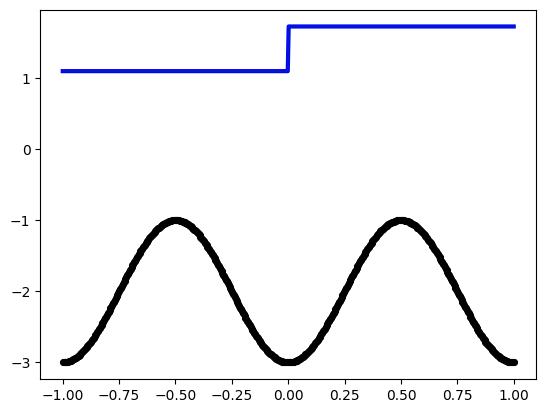

In [17]:
# Example predictions at init
plt.plot(x_test, means.mean(axis=(-2, -1)), color='blue', linewidth=3)  # Mixture-mean

for i in range(means.shape[1]):
    plt.plot(x_test, means[:, i], color='green', alpha=0.2)  # Mixture-components

plt.scatter(x_test, y_test, c='black', s=10, marker='o', linewidth=2, label='Test Predict-Points')

# Dummy Optimization/ Amortization procedure

In [23]:
# Define how the model loss should be computed

def posterior_loss(
    params: flax.typing.VariableDict,
    key: flax.typing.PRNGKey,
    sampling_fun: Callable[
        [flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ] = data_sampler
):
    # Sample datasets from p(X, Y, Z)
    key_data, key_model = jax.random.split(key)
    xs, ys = jax.vmap(data_sampler)(jax.random.split(key_data, num=batch_size))
    xs, ys = xs[..., None], ys[..., None]
    
    # Split into context- and target-points.
    X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples, ), axis=1)
    y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples, ), axis=1)

    # Compute ELBO over batch of datasets
    elbos = jax.vmap(partial(
        model.apply, 
        params, 
        beta=kl_penalty, k=num_posterior_mc, 
        method=model.elbo
    ))(
        X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, num=batch_size)}
    )
    
    return -elbos.mean()


def posterior_loss_filtered(
    params: flax.typing.VariableDict,
    key: flax.typing.PRNGKey,
    sampling_fun: Callable[
        [flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ] = data_sampler
):
    # Sample datasets from p(X, Y, Z)
    key_data, key_model = jax.random.split(key)
    xs, ys = jax.vmap(data_sampler)(jax.random.split(key_data, num=batch_size))
    xs, ys = xs[..., None], ys[..., None]
    
    # Split into context- and target-points.
    X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples, ), axis=1)
    y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples, ), axis=1)

    # Compute ELBO over batch of datasets
    elbos = jax.vmap(partial(
        model.apply, 
        params, 
        beta=kl_penalty, k=num_posterior_mc, 
        method=model.elbo
    ))(
        X, y, x_test, y_test, rngs={'default': jax.random.split(key_model, num=batch_size)}
    )

    # Mask out all samples with higher data-likelihood than the worst 40%
    q40 = jnp.percentile(elbos, 40)
    mask = elbos <= q40
    
    return -(elbos * mask / mask.sum()).sum()


In [24]:
@jax.jit
def step(
    theta: flax.typing.VariableDict, 
    opt_state: optax.OptState, 
    random_key: flax.typing.PRNGKey
) -> tuple[flax.typing.VariableDict, optax.OptState, jax.Array]:
    # Implements a generic SGD Step
    
    value, grad = jax.value_and_grad(posterior_loss_filtered, argnums=0)(theta, random_key)
    # value, grad = jax.value_and_grad(posterior_loss, argnums=0)(theta, random_key)
    
    updates, opt_state = optimizer.update(grad, opt_state, theta)
    theta = optax.apply_updates(theta, updates)
    
    return theta, opt_state, value


In [25]:
def body(carry, x):
    params, opt_state, key = carry

    key_carry, key_step = jax.random.split(key)
    params, opt_state, value = step(params, opt_state, key_step)

    return (params, opt_state, key_carry), value


@partial(jax.jit, static_argnums=3)
def scan_train(params, opt_state, key, num: int):
    
    last, out = jax.lax.scan(body, (params, opt_state, key), xs=None, length=num)

    params, opt_state, _ = last
    
    return params, opt_state, out

In [26]:
scan_chunk = 100

# Initialize the Optimization.
rng, key = jax.random.split(rng)

last_key = key
print(last_key)

params = params0 = model.init(
    {'params': key, 'default': key}, 
    xs[:, None], ys[:, None], x_test[:1, None]
)

optimizer = optax.chain(
    optax.clip(.1),
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate=1e-3, weight_decay=1e-6),
)
opt_state = optimizer.init(params)

best, best_params = jnp.inf, params
losses = list()
for i in (pbar := tqdm.trange(10_000 // scan_chunk, desc='Optimizing params. ')):
    
    rng, key = jax.random.split(rng)
    # params_new, opt_state, loss = step(params, opt_state, key)
    params_new, opt_state, loss_arr = scan_train(params, opt_state, key, scan_chunk)

    losses.append(loss_arr)

    if loss_arr.min() < best:
        best = loss_arr.min()
        best_params = params_new
    
    if jnp.isnan(loss_arr).any():
        break
    else:
        params = params_new
    
    pbar.set_description(f'Optimizing params. Loss: {loss_arr.min():.4f}')

params = best_params
losses = jnp.asarray(losses).ravel()

Array((), dtype=key<fry>) overlaying:
[2192541334  702754492]


Optimizing params. Loss: 1.3201: 100%|██████████| 100/100 [17:12<00:00, 10.33s/it]


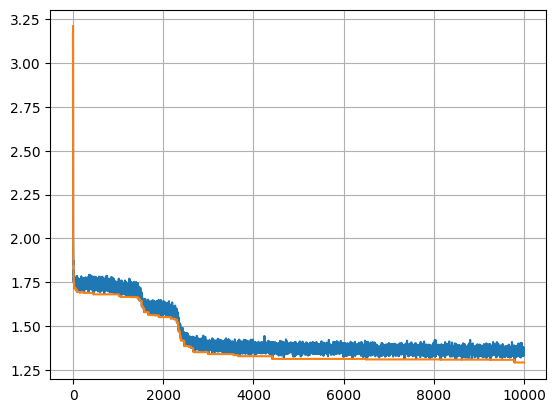

In [27]:
losses = jnp.asarray(losses).ravel()
plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()
# plt.xlim([10, len(losses)])
# plt.ylim([0, 3])

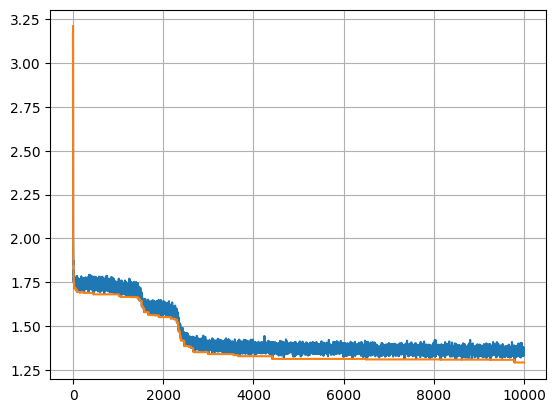

In [28]:
# Using q40 filtering

plt.plot(losses)
plt.plot(jnp.ufunc(jnp.minimum, nin=2, nout=1).accumulate(jnp.asarray(losses)))
plt.grid()
# plt.xlim([10, len(losses)])
# plt.ylim([0, 3])

# Test-predictions after training

In [29]:
rng, test_key = jax.random.split(rng)
print(test_key)

Array((), dtype=key<fry>) overlaying:
[3705273569 2407791898]


In [30]:
# Test predictions on functions from the training-distribution
key_data, key_model = jax.random.split(test_key)

x_train, y_train = data_sampler(test_key)
x_train, y_train = x_train[..., None], y_train[..., None]

# Split into context- and target-points.
X, x_predict_train = jnp.split(x_train, indices_or_sections=(num_context_samples, ))
y, y_predict_train = jnp.split(y_train, indices_or_sections=(num_context_samples, ))

# Compute ELBO over batch of datasets
# means, stds = model.apply(
#     params, 
#     X, y, x_test[..., None],
#     k=10,
#     rngs={'default': jax.random.key(0)}
# )
means, stds = model.apply(
    params, 
    X, y, x_test[..., None],
    k=1,
    rngs={'default': key_model}
)
print('prediction-shape', means.shape, stds.shape)  # dim: (len(x_test), k, 1)

prediction-shape (512, 1, 1) (512, 1, 1)


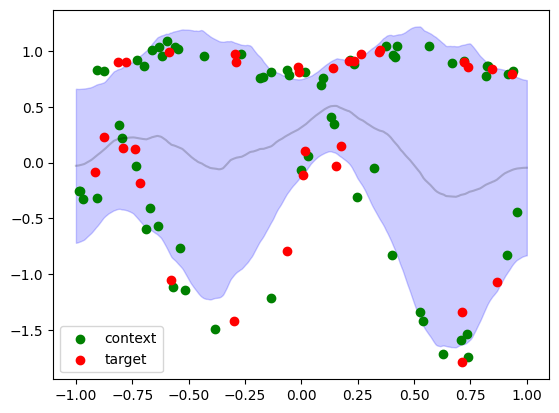

In [36]:
# plt.plot(x_test, means.mean(axis=(-2, -1)), label='predict', color='blue')
# plt.fill_between(
#     x_test,
#     means.mean(axis=(-2, -1)) + stds.mean(axis=(-2, -1)),
#     means.mean(axis=(-2, -1)) - stds.mean(axis=(-2, -1)),
#     color='blue', alpha=0.2
# )

for i in range(means.shape[1]):
    plt.plot(x_test, means[:, i], color='black', alpha=0.2)  # Mixture-components
    plt.fill_between(
        x_test,
        means[:, i, 0] + stds[:, i, 0],
        means[:, i, 0] - stds[:, i, 0],
        color='blue', alpha=0.2
    )

plt.scatter(X, y, color='green', label='context')
plt.scatter(x_predict_train, y_predict_train, color='red', label='target')

plt.legend()

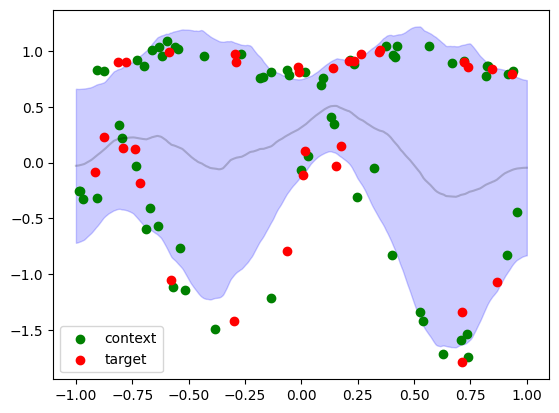

In [37]:
# Using q40 filtering

# plt.plot(x_test, means.mean(axis=(-2, -1)), label='predict', color='blue')
# plt.fill_between(
#     x_test,
#     means.mean(axis=(-2, -1)) + stds.mean(axis=(-2, -1)),
#     means.mean(axis=(-2, -1)) - stds.mean(axis=(-2, -1)),
#     color='blue', alpha=0.2
# )

for i in range(means.shape[1]):
    plt.plot(x_test, means[:, i], color='black', alpha=0.2)  # Mixture-components
    plt.fill_between(
        x_test,
        means[:, i, 0] + stds[:, i, 0],
        means[:, i, 0] - stds[:, i, 0],
        color='blue', alpha=0.2
    )

plt.scatter(X, y, color='green', label='context')
plt.scatter(x_predict_train, y_predict_train, color='red', label='target')

plt.legend()

In [38]:
# Test predictions on our test-function
means, stds = model.apply(
    params, 
    xs[:, None], ys[:, None], x_test[:, None], 
    k=1,
    rngs={'default': key_model}
)
print('prediction-shape', means.shape, stds.shape)  # dim: (len(x_test), k, 1)

prediction-shape (512, 1, 1) (512, 1, 1)


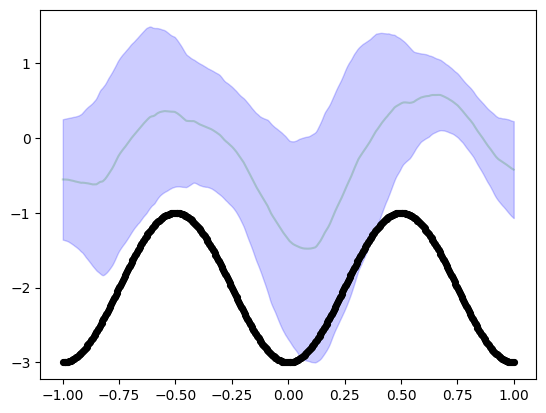

In [39]:
# Example predictions at init
# plt.plot(x_test, means.mean(axis=(-2, -1)), color='blue', linewidth=3)  # Mixture-mean
# plt.fill_between(
#     x_test,
#     means.mean(axis=(-2, -1)) + stds.mean(axis=(-2, -1)),
#     means.mean(axis=(-2, -1)) - stds.mean(axis=(-2, -1)),
#     color='blue', alpha=0.2
# )

for i in range(means.shape[1]):
    plt.plot(x_test, means[:, i], color='green', alpha=0.2)  # Mixture-components
    plt.fill_between(
        x_test,
        means[:, i, 0] + stds[:, i, 0],
        means[:, i, 0] - stds[:, i, 0],
        color='blue', alpha=0.2
    )

plt.scatter(x_test, y_test, c='black', s=10, marker='o', linewidth=2, label='Test Predict-Points')
plt.legend()

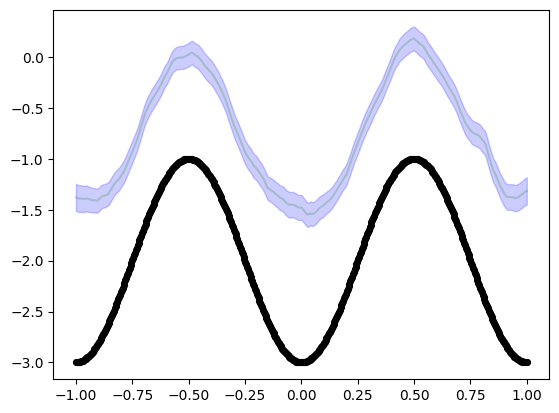

In [28]:
# Using q40 filtering

# Example predictions at init
# plt.plot(x_test, means.mean(axis=(-2, -1)), color='blue', linewidth=3)  # Mixture-mean
# plt.fill_between(
#     x_test,
#     means.mean(axis=(-2, -1)) + stds.mean(axis=(-2, -1)),
#     means.mean(axis=(-2, -1)) - stds.mean(axis=(-2, -1)),
#     color='blue', alpha=0.2
# )

for i in range(means.shape[1]):
    plt.plot(x_test, means[:, i], color='green', alpha=0.2)  # Mixture-components
    plt.fill_between(
        x_test,
        means[:, i, 0] + stds[:, i, 0],
        means[:, i, 0] - stds[:, i, 0],
        color='blue', alpha=0.2
    )

plt.scatter(x_test, y_test, c='black', s=10, marker='o', linewidth=2, label='Test Predict-Points')

# Evolution

In [94]:
def train_model_on_task(model, params, task, key):
    def create_data_sampler(task):
        fourier_modules = [Fourier(n=fp['n'], amplitude=fp['amplitude'], period=fp['period']) for fp in task['fourier_params']]
        shifted_modules = [Shift(fm, y_shift=fp['y_shift']) for fm, fp in zip(fourier_modules, task['fourier_params'])]
        noisy_modules = [WhiteNoise(sm, scale=fp['noise_scale']) for sm, fp in zip(shifted_modules, task['fourier_params'])]
        mixture = Mixture(noisy_modules)
        return partial(joint, mixture, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))
    data_sampler = create_data_sampler(task)
    xs, ys = data_sampler(key)
    
    # Check and reshape if necessary
    if len(xs.shape) == 1:
        xs = xs.reshape(-1, 1)
    if len(ys.shape) == 1:
        ys = ys.reshape(-1, 1)
    
    assert xs.shape[1] == 1, "xs should have shape (num_samples, 1)"
    assert ys.shape[1] == 1, "ys should have shape (num_samples, 1)"
    
    if xs.shape[0] >= num_context_samples:
        X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples,), axis=0)
        y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples,), axis=0)
    else:
        raise ValueError("Not enough samples to split into context and target points")
    
    optimizer = optax.adam(learning_rate=1e-3)
    opt_state = optimizer.init(params)
    
    @jax.jit
    def update(params, opt_state, key):
        loss, grads = jax.value_and_grad(posterior_loss)(params, key)
        updates, opt_state = optimizer.update(grads, opt_state)
        return optax.apply_updates(params, updates), opt_state, loss
    
    for epoch in range(num_epochs):
        params, opt_state, loss = update(params, opt_state, key)
    
    return params

In [95]:
def evaluate_model(model, params, task, key):
    data_sampler = create_data_sampler(task)
    xs, ys = data_sampler(key)
    X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples,), axis=1)
    y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples,), axis=1)
    predictions, uncertainties = model.apply(params, X, y, x_test, method=model.predict)
    mse = jnp.mean((predictions - y_test)**2)
    nll = -model.apply(params, X, y, x_test, y_test, method=model.log_likelihood)
    return mse, nll

In [96]:
chromosome = {
    'fourier_params': [
        {'n': 4, 'amplitude': 0.5, 'period': 1.0, 'y_shift': -2, 'noise_scale': 0.05},
        {'n': 2, 'amplitude': 0.5, 'period': 1.0, 'y_shift': 0.0, 'noise_scale': 0.2},
        {'n': 6, 'amplitude': 0.5, 'period': 2.0, 'y_shift': 2, 'noise_scale': 0.1}
    ]
}

In [97]:
def initialize_population(pop_size):
    population = []
    for _ in range(pop_size):
        chromosome = {
            'fourier_params': [
                {'n': np.random.randint(1, 10), 'amplitude': np.random.uniform(0.1, 1.0), 'period': np.random.uniform(0.5, 2.0), 'y_shift': np.random.uniform(-2, 2), 'noise_scale': np.random.uniform(0.01, 0.2)}
                for _ in range(3)
            ]
        }
        population.append(chromosome)
    logging.info(f"Initialized population with {pop_size} chromosomes.")
    return population

In [98]:
def fitness_function(model, params, task, key):
    def create_data_sampler(task):
        fourier_modules = [Fourier(n=fp['n'], amplitude=fp['amplitude'], period=fp['period']) for fp in task['fourier_params']]
        shifted_modules = [Shift(fm, y_shift=fp['y_shift']) for fm, fp in zip(fourier_modules, task['fourier_params'])]
        noisy_modules = [WhiteNoise(sm, scale=fp['noise_scale']) for sm, fp in zip(shifted_modules, task['fourier_params'])]
        mixture = Mixture(noisy_modules)
        return partial(joint, mixture, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))

    data_sampler = create_data_sampler(task)
    xs, ys = data_sampler(key)
        # Check and reshape if necessary
    if len(xs.shape) == 1:
        xs = xs.reshape(-1, 1)
    if len(ys.shape) == 1:
        ys = ys.reshape(-1, 1)
    
    assert xs.shape[1] == 1, "xs should have shape (num_samples, 1)"
    assert ys.shape[1] == 1, "ys should have shape (num_samples, 1)"
    
    # Ensure the array can be split
    if xs.shape[0] >= num_context_samples:
        X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples,), axis=0)
        y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples,), axis=0)
        
        elbo = model.apply(params, X, y, x_test, y_test, rngs={'default': key}, method=model.elbo)
        return -elbo.mean()
    else:
        raise ValueError("Not enough samples to split into context and target points")

In [99]:
def select_parents(population, fitnesses, num_parents):
    selected_indices = np.argsort(fitnesses)[:num_parents]
    return [population[i] for i in selected_indices]


In [100]:
def crossover(parent1, parent2):
    child = {'fourier_params': []}
    for fp1, fp2 in zip(parent1['fourier_params'], parent2['fourier_params']):
        new_fp = {key: np.random.choice([fp1[key], fp2[key]]) for key in fp1.keys()}
        child['fourier_params'].append(new_fp)
    return child

def mutate(chromosome, mutation_rate=0.1):
    for fp in chromosome['fourier_params']:
        if np.random.rand() < mutation_rate:
            fp['n'] = np.random.randint(1, 10)
            fp['amplitude'] = np.random.uniform(0.1, 1.0)
            fp['period'] = np.random.uniform(0.5, 2.0)
            fp['y_shift'] = np.random.uniform(-2, 2)
            fp['noise_scale'] = np.random.uniform(0.01, 0.2)
    return chromosome

In [101]:
def evolutionary_training(model, params, pop_size, num_generations, num_parents, mutation_rate, rng):
    population = initialize_population(pop_size)
    best_params = params
    best_fitness = float('inf')

    for generation in range(num_generations):
        logging.info(f"Generation {generation+1}/{num_generations}")
        fitnesses = []
        for idx, task in enumerate(population):
            rng, key = jax.random.split(rng)
            fitness = fitness_function(model, params, task, key)
            fitnesses.append(fitness)
            logging.info(f"Evaluated fitness for task {idx+1}/{pop_size}: {fitness}")

        
        parents = select_parents(population, fitnesses, num_parents)
        new_population = []
        
        for _ in range(pop_size):
            parent1, parent2 = np.random.choice(parents, 2, replace=False)
            child = crossover(parent1, parent2)
            child = mutate(child, mutation_rate)
            new_population.append(child)
            logging.info("Performed crossover and mutation to generate a new child.")

        
        population = new_population
        best_task = population[np.argmin(fitnesses)]
        if np.min(fitnesses) < best_fitness:
            best_fitness = np.min(fitnesses)
            rng, key = jax.random.split(rng)
            best_params = train_model_on_task(model, params, best_task, key)  # Train the model on the best task
            logging.info(f"New best fitness: {best_fitness}")
            
    return best_params


In [112]:
import numpy as np
import logging

# Initialize model parameters
# Initialize the random number generator
rng = jax.random.PRNGKey(0)

# params = model.init(rng, example_input)
params = model.init({'params': rng, 'default': rng}, xs[:, None], ys[:, None], xs[:3, None])

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Adjust parameters for quick testing
pop_size = 10        # Reduce population size
num_generations = 10 # Reduce number of generations
num_parents = 5      # Reduce number of parents
num_context_samples = 5
num_target_samples = 5
num_epochs = 10



# Train and evaluate using evolutionary approach
evolutionary_params = evolutionary_training(model, params, pop_size=pop_size, num_generations=num_generations, num_parents=num_parents, mutation_rate=0.1, rng = rng)
evolutionary_results = [evaluate_model(model, evolutionary_params, task, rng) for task in test_tasks]

# Train and evaluate using baseline approach
#baseline_tasks = generate_baseline_tasks(num_tasks)
#baseline_results = [evaluate_model(model, params, task, rng) for task in baseline_tasks]

# Compare Results
evolutionary_mse, evolutionary_nll = zip(*evolutionary_results)
#baseline_mse, baseline_nll = zip(*baseline_results)

print(f'Evolutionary Approach - MSE: {jnp.mean(evolutionary_mse)}, NLL: {jnp.mean(evolutionary_nll)}')
#print(f'Baseline Approach - MSE: {jnp.mean(baseline_mse)}, NLL: {jnp.mean(baseline_nll)}')


2024-06-03 15:43:56,909 - INFO - Initialized population with 10 chromosomes.
2024-06-03 15:43:56,909 - INFO - Generation 1/10
2024-06-03 15:43:58,495 - INFO - Evaluated fitness for task 1/10: nan
2024-06-03 15:43:58,997 - INFO - Evaluated fitness for task 2/10: nan
2024-06-03 15:43:59,506 - INFO - Evaluated fitness for task 3/10: 9.411109924316406


KeyboardInterrupt: 

In [113]:
# Construct the NP model

embedding_xs = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
embedding_ys = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)
embedding_both = MLP([64, 64], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True)

projection_posterior = NonLinearMVN(MLP([128, 64], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True))
output_model = nn.Sequential([
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    ResBlock(
        MLP([128, 128], activation=jax.nn.leaky_relu, activate_final=True, use_layernorm=True),
    ),
    nn.Dense(2)
])
# output_model = MLP([64, 64, 2], activation=jax.nn.leaky_relu, activate_final=False, use_layernorm=True)
projection_outputs = NonLinearMVN(output_model)

posterior_aggregator = MeanAggregator(projection_posterior)
# posterior_aggregator = SequenceAggregator(projection_posterior)

model = MixtureNeuralProcess(
    embedding_xs, embedding_ys, embedding_both, 
    posterior_aggregator, 
    projection_outputs
)

rng, key = jax.random.split(rng)
params = model.init({'params': key, 'default': key}, xs[:, None], ys[:, None], xs[:3, None])
print('params-shape', jax.tree_map(jnp.shape, params))

params-shape {'params': {'embed_both': {'Dense_0': {'bias': (64,), 'kernel': (128, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_xs': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'embed_ys': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}, 'LayerNorm_0': {'bias': (64,), 'scale': (64,)}, 'LayerNorm_1': {'bias': (64,), 'scale': (64,)}}, 'likelihood': {'projection': {'layers_0': {'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'module': {'Dense_0': {'bias': (128,), 'kernel': (128, 128)}, 'Dense_1': {'bias': (128,), 'kernel': (128, 128)}, 'LayerNorm_0': {'bias': (128,), 'scale': (128,)}, 'LayerNorm_1': {'bias': (128,), 'scale': (128,)}}}, 'layers_1': {'LayerNorm_0': {'bias': (128,), 'sc

C:\Users\onerk\AppData\Local\Temp\ipykernel_6312\566903709.py:31: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  print('params-shape', jax.tree_map(jnp.shape, params))


In [120]:
import jax
import jax.numpy as jnp
import optax
from flax import linen as nn
import numpy as np
from functools import partial
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the example input shape
example_input = jnp.zeros((20, 1))  # Adjust the shape according to your input data

# # Placeholder for the actual model
# class MixtureNeuralProcess(nn.Module):
#     def __call__(self, x, y, z):
#         pass

# Initialize the random number generator
rng = jax.random.PRNGKey(0)

# Initialize model parameters
rng, key = jax.random.split(rng)
params = model.init({'params': key, 'default': key}, xs[:, None], ys[:, None], xs[:3, None])

# Adjust parameters for quick testing
pop_size = 10        # Reduce population size
num_generations = 3 # Reduce number of generations
num_parents = 2      # Reduce number of parents
num_context_samples = 5
num_target_samples = 5

# Function to initialize population
def initialize_population(pop_size):
    population = []
    for _ in range(pop_size):
        chromosome = {
            'fourier_params': [
                {'n': np.random.randint(1, 10), 'amplitude': np.random.uniform(0.1, 1.0), 'period': np.random.uniform(0.5, 2.0), 'y_shift': np.random.uniform(-2, 2), 'noise_scale': np.random.uniform(0.01, 0.2)}
                for _ in range(3)
            ]
        }
        population.append(chromosome)
    logging.info(f"Initialized population with {pop_size} chromosomes.")
    return population

# Function to evaluate fitness of each task
def fitness_function(model, params, task, key):
    def create_data_sampler(task):
        fourier_modules = [Fourier(n=fp['n'], amplitude=fp['amplitude'], period=fp['period']) for fp in task['fourier_params']]
        shifted_modules = [Shift(fm, y_shift=fp['y_shift']) for fm, fp in zip(fourier_modules, task['fourier_params'])]
        noisy_modules = [WhiteNoise(sm, scale=fp['noise_scale']) for sm, fp in zip(shifted_modules, task['fourier_params'])]
        mixture = Mixture(noisy_modules)
        return partial(joint, mixture, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))

    data_sampler = create_data_sampler(task)
    xs, ys = data_sampler(key)
    
    if len(xs.shape) == 1:
        xs = xs.reshape(-1, 1)
    if len(ys.shape) == 1:
        ys = ys.reshape(-1, 1)
    
    assert xs.shape[1] == 1, "xs should have shape (num_samples, 1)"
    assert ys.shape[1] == 1, "ys should have shape (num_samples, 1)"
    
    if xs.shape[0] >= num_context_samples:
        X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples,), axis=0)
        y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples,), axis=0)
        
        elbo = model.apply(params, X, y, x_test, y_test, k=num_posterior_mc, beta=kl_penalty, rngs={'default': key}, method=model.elbo)
        return -elbo.mean()
    else:
        raise ValueError("Not enough samples to split into context and target points")


# Function to evaluate the model on test tasks
def evaluate_model(model, params, task, key):
    def create_data_sampler(task):
        fourier_modules = [Fourier(n=fp['n'], amplitude=fp['amplitude'], period=fp['period']) for fp in task['fourier_params']]
        shifted_modules = [Shift(fm, y_shift=fp['y_shift']) for fm, fp in zip(fourier_modules, task['fourier_params'])]
        noisy_modules = [WhiteNoise(sm, scale=fp['noise_scale']) for sm, fp in zip(shifted_modules, task['fourier_params'])]
        mixture = Mixture(noisy_modules)
        return partial(joint, mixture, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))

    data_sampler = create_data_sampler(task)
    xs, ys = data_sampler(key)
    
    if len(xs.shape) == 1:
        xs = xs.reshape(-1, 1)
    if len(ys.shape) == 1:
        ys = ys.reshape(-1, 1)
    
    assert xs.shape[1] == 1, "xs should have shape (num_samples, 1)"
    assert ys.shape[1] == 1, "ys should have shape (num_samples, 1)"
    
    if xs.shape[0] >= num_context_samples:
        X, x_test = jnp.split(xs, indices_or_sections=(num_context_samples,), axis=0)
        y, y_test = jnp.split(ys, indices_or_sections=(num_context_samples,), axis=0)
        
        mean, stddev = model.apply(params, X, y, x_test, rngs={'default': key})


        logging.info(f"Shape of mean: {mean.shape}")
        logging.info(f"Shape of y_test: {y_test.shape}")
        
        y_test_expanded = jnp.expand_dims(y_test, axis=1)  # Add an extra dimension
        y_test_expanded = jnp.broadcast_to(y_test_expanded, mean.shape)  # Match mean shape

        
        mse = jnp.mean((mean - y_test_expanded) ** 2)
        nll = -jnp.mean(model.apply(params, X, y, x_test, y_test_expanded, rngs={'default': key}, method=model.elbo))
        return mse, nll

    else:
        raise ValueError("Not enough samples to split into context and target points")


# Evolutionary training function
def evolutionary_training(model, params, pop_size, num_generations, num_parents, mutation_rate, rng):
    population = initialize_population(pop_size)
    best_params = params
    best_fitness = float('inf')

    for generation in range(num_generations):
        logging.info(f"Generation {generation+1}/{num_generations}")
        fitnesses = []
        for idx, task in enumerate(population):
            rng, key = jax.random.split(rng)
            fitness = fitness_function(model, params, task, key)
            fitnesses.append(fitness)
            logging.info(f"Evaluated fitness for task {idx+1}/{pop_size}: {fitness}")

        parents = select_parents(population, fitnesses, num_parents)
        new_population = []
        
        for _ in range(pop_size):
            parent1, parent2 = np.random.choice(parents, 2, replace=False)
            child = crossover(parent1, parent2)
            child = mutate(child, mutation_rate)
            new_population.append(child)
            logging.info("Performed crossover and mutation to generate a new child.")

        population = new_population
        best_task = population[np.argmin(fitnesses)]
        if np.min(fitnesses) < best_fitness:
            best_fitness = np.min(fitnesses)
            best_params = train_model_on_task(model, params, best_task, rng)
            logging.info(f"New best fitness: {best_fitness}")

    return best_params

def train_model_on_task(model, params, task, rng):
    def create_data_sampler(task):
        fourier_modules = [Fourier(n=fp['n'], amplitude=fp['amplitude'], period=fp['period']) for fp in task['fourier_params']]
        shifted_modules = [Shift(fm, y_shift=fp['y_shift']) for fm, fp in zip(fourier_modules, task['fourier_params'])]
        noisy_modules = [WhiteNoise(sm, scale=fp['noise_scale']) for sm, fp in zip(shifted_modules, task['fourier_params'])]
        mixture = Mixture(noisy_modules)
        return partial(joint, mixture, partial(uniform, n=num_target_samples + num_context_samples, bounds=(-1, 1)))

    data_sampler = create_data_sampler(task)
    optimizer = optax.adam(learning_rate=1e-3)
    opt_state = optimizer.init(params)
    
    @jax.jit
    def step(params, opt_state, key):
        loss, grads = jax.value_and_grad(posterior_loss)(params, key, data_sampler)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss
    
    for _ in range(100):  # Reduce number of iterations for quick test
        rng, key = jax.random.split(rng)
        params, opt_state, loss = step(params, opt_state, key)
    
    return params

# Example usage
rng = jax.random.PRNGKey(0)
example_input = jnp.zeros((20, 1))  # Adjust the shape according to your input data
params = model.init({'params': rng, 'default': rng}, example_input, example_input, example_input)

best_params = evolutionary_training(model, params, pop_size=pop_size, num_generations=num_generations, num_parents=num_parents, mutation_rate=0.1, rng=rng)

# Define test tasks
test_tasks = initialize_population(5)  # Generate a small set of test tasks

# Evaluate the trained model on test tasks
evolutionary_results = [evaluate_model(model, best_params, task, rng) for task in test_tasks]

# Log the results
for idx, result in enumerate(evolutionary_results):
    logging.info(f"Test Task {idx+1}/{len(test_tasks)} - MSE: {result[0]}, NLL: {result[1]}")

logging.info("Evolutionary training and evaluation completed.")



2024-06-03 18:18:53,325 - INFO - Initialized population with 10 chromosomes.
2024-06-03 18:18:53,325 - INFO - Generation 1/3
2024-06-03 18:18:53,793 - INFO - Evaluated fitness for task 1/10: 2.645763874053955
2024-06-03 18:18:54,242 - INFO - Evaluated fitness for task 2/10: 2.168407440185547
2024-06-03 18:18:54,745 - INFO - Evaluated fitness for task 3/10: nan
2024-06-03 18:18:55,232 - INFO - Evaluated fitness for task 4/10: nan
2024-06-03 18:18:55,740 - INFO - Evaluated fitness for task 5/10: 1.7218328714370728
2024-06-03 18:18:56,225 - INFO - Evaluated fitness for task 6/10: nan
2024-06-03 18:18:56,696 - INFO - Evaluated fitness for task 7/10: 2.1006968021392822
2024-06-03 18:18:59,533 - INFO - Evaluated fitness for task 8/10: 1.4052261114120483
2024-06-03 18:19:00,118 - INFO - Evaluated fitness for task 9/10: 2.2385289669036865
2024-06-03 18:19:00,627 - INFO - Evaluated fitness for task 10/10: 1.9660760164260864
2024-06-03 18:19:00,627 - INFO - Performed crossover and mutation to ge

TypeError: Cannot concatenate arrays with different numbers of dimensions: got (5, 1), (5, 10, 1).